In [1]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import pandas as pd
import datetime
import matplotlib.ticker as ticker
import pymc3 as pm
import arviz as az
sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
#import covid19_inference as cov19
from header_plotting import *


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

countries = ['England', 'Czechia', 'Scotland', 'Spain', 'Germany', 'Austria',
       'France', 'Slovakia', 'Belgium', 'Italy', 'Portugal',#'Netherlands'
            ]
traces, models, dls = [], [], []
for country in tqdm(countries):
    #'UEFA-beta=False-country=England-offset_games=0-draw_delay=True-weighted_alpha_prior=0-prior_delay=-1-width_delay_prior=0.1-sigma_incubation=-1.0-median_width_delay=1.0-tune=200-draws=300-max_treedepth=10.pickled'
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_data/main_traces/run"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.33"+
        f"-len=normal"+
        f"-abs_sine=False"+
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    #print(fstr(4000, 8000, 12))
    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None: 
        print(fstr(tune, draws, max_treedepth), " not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)

  0%|          | 0/11 [00:00<?, ?it/s]

Use 4000 sample runs for England
Use 4000 sample runs for Czechia
Use 4000 sample runs for Scotland
Use 4000 sample runs for Spain
Use 4000 sample runs for Germany
Use 4000 sample runs for Austria
Use 4000 sample runs for France
Use 4000 sample runs for Slovakia
Use 4000 sample runs for Belgium
Use 4000 sample runs for Italy
Use 4000 sample runs for Portugal


In [18]:
from covid19_soccer.plot.utils import get_from_trace
from covid19_soccer.plot.other import HandlerPatchImage,PatchImage,MulticolorPatchHandler,MulticolorPatch
from matplotlib.patches import Patch, Rectangle
from covid19_soccer.plot.utils import get_flag
def legend(ax,colors,loc="center"):
    # Legend
    image_urls = []
    iso2 = []
    for i, dl in enumerate(dls):
        image_urls.append(get_flag(dl.countries_iso2[0].lower(),"/tmp/"))
        iso2.append(dl.countries_iso2[0].replace("GB-", ""))
        
        
        
    lines = []
    for i,color in enumerate(colors):
        lines.append(MulticolorPatch(colors=[color]))
    ax.legend(
        lines,
        iso2,
        loc=loc,
        handler_map={MulticolorPatch:MulticolorPatchHandler()},
        fontsize=6,
    )

    
def plot_var(ax, dat, y_pos, color, ci=0.95):
    """ Plots horizontal lines in typical style for a variable. Only works for ndim=1
    
        Parameters
        ----------
        ax:
            Matplotlib axes
        trace:
            Trace for getting the var
        var: string
            Var name
        y_pos: 
            Position of lineplot
        ci: number
            Ci to use for highlighting
    """


    # Get percentiles
    m,l2,l1,u1,u2 = np.percentile(dat,q=(50,2.5,25,75,97.5))

    lines = ax.hlines(
        y=y_pos,
        xmin=l2,
        xmax=u2,
        lw=1.5,
        zorder=9,
        color=color,
        capstyle='round'
    )
    
    lines = ax.hlines(
        y=y_pos,
        xmin=l1,
        xmax=u1,
        lw=2.5,
        zorder=10,
        color=color,
        capstyle='round'
    )
    ax.scatter(
        x=m,
        y=y_pos,
        marker="o",
        s=10,
        c="white",
        zorder=11,
        edgecolor=color,
        capstyle='round'
    )
    
    return ax



timetable = pd.read_csv("../../data/em_game_data.csv",header=2)
timetable = timetable[~timetable["id"].str.contains("a")] # Filter extra games we added for validation these are suffixed with a
timetable = timetable[~timetable["id"].str.contains("b")] # Filter extra games we added for validation these are suffixed with b
timetable[" date"]= pd.to_datetime(timetable[" date"])

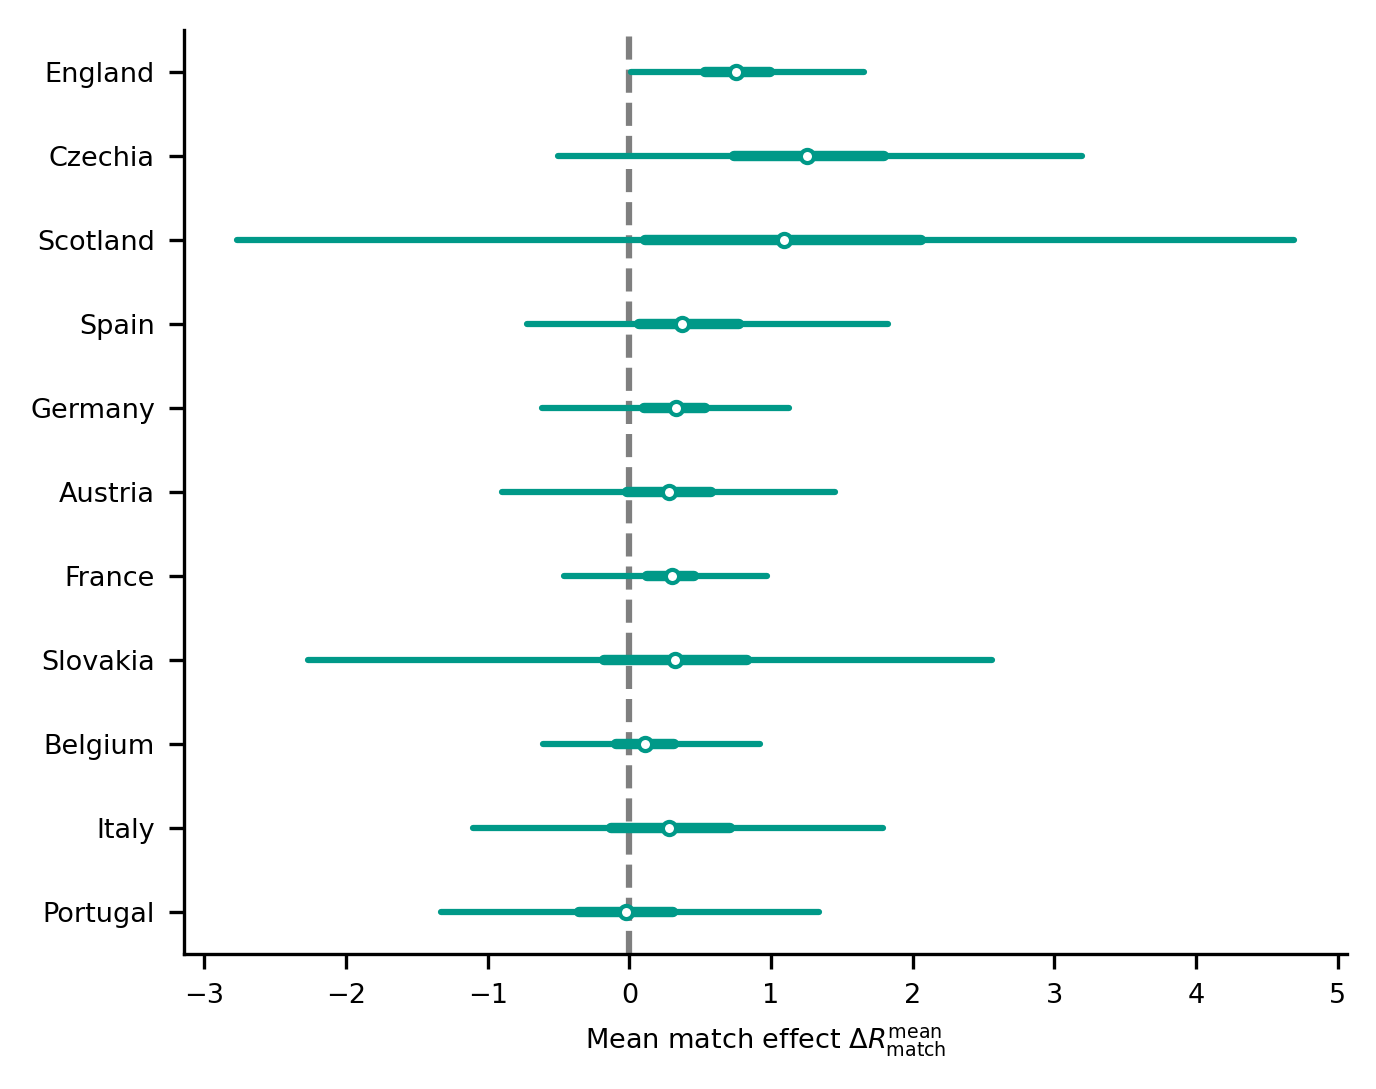

In [19]:
import arviz as az
from covid19_soccer.plot.rcParams import *


fig, ax = plt.subplots(1,1,figsize=(5,4))

for i, (trace, country) in enumerate(zip(traces,countries)):
    # Get datapoints
    dat = get_from_trace("alpha_mean",trace)
    plot_var(ax, dat, country, color=rcParams["color_model"])

ax.set_ylim(i+0.5,-0.5)
ax.set_xlabel(r"Mean match effect $\Delta R^\mathrm{mean}_\mathrm{match}$")
ax.axvline(0,ls="--",color="tab:gray")
plt.show()
fig.savefig(f"../figures/SI/alpha_mean.pdf", **save_kwargs)
fig.savefig(f"../figures/SI/alpha_mean.png", **save_kwargs)
plt.close(fig=fig)


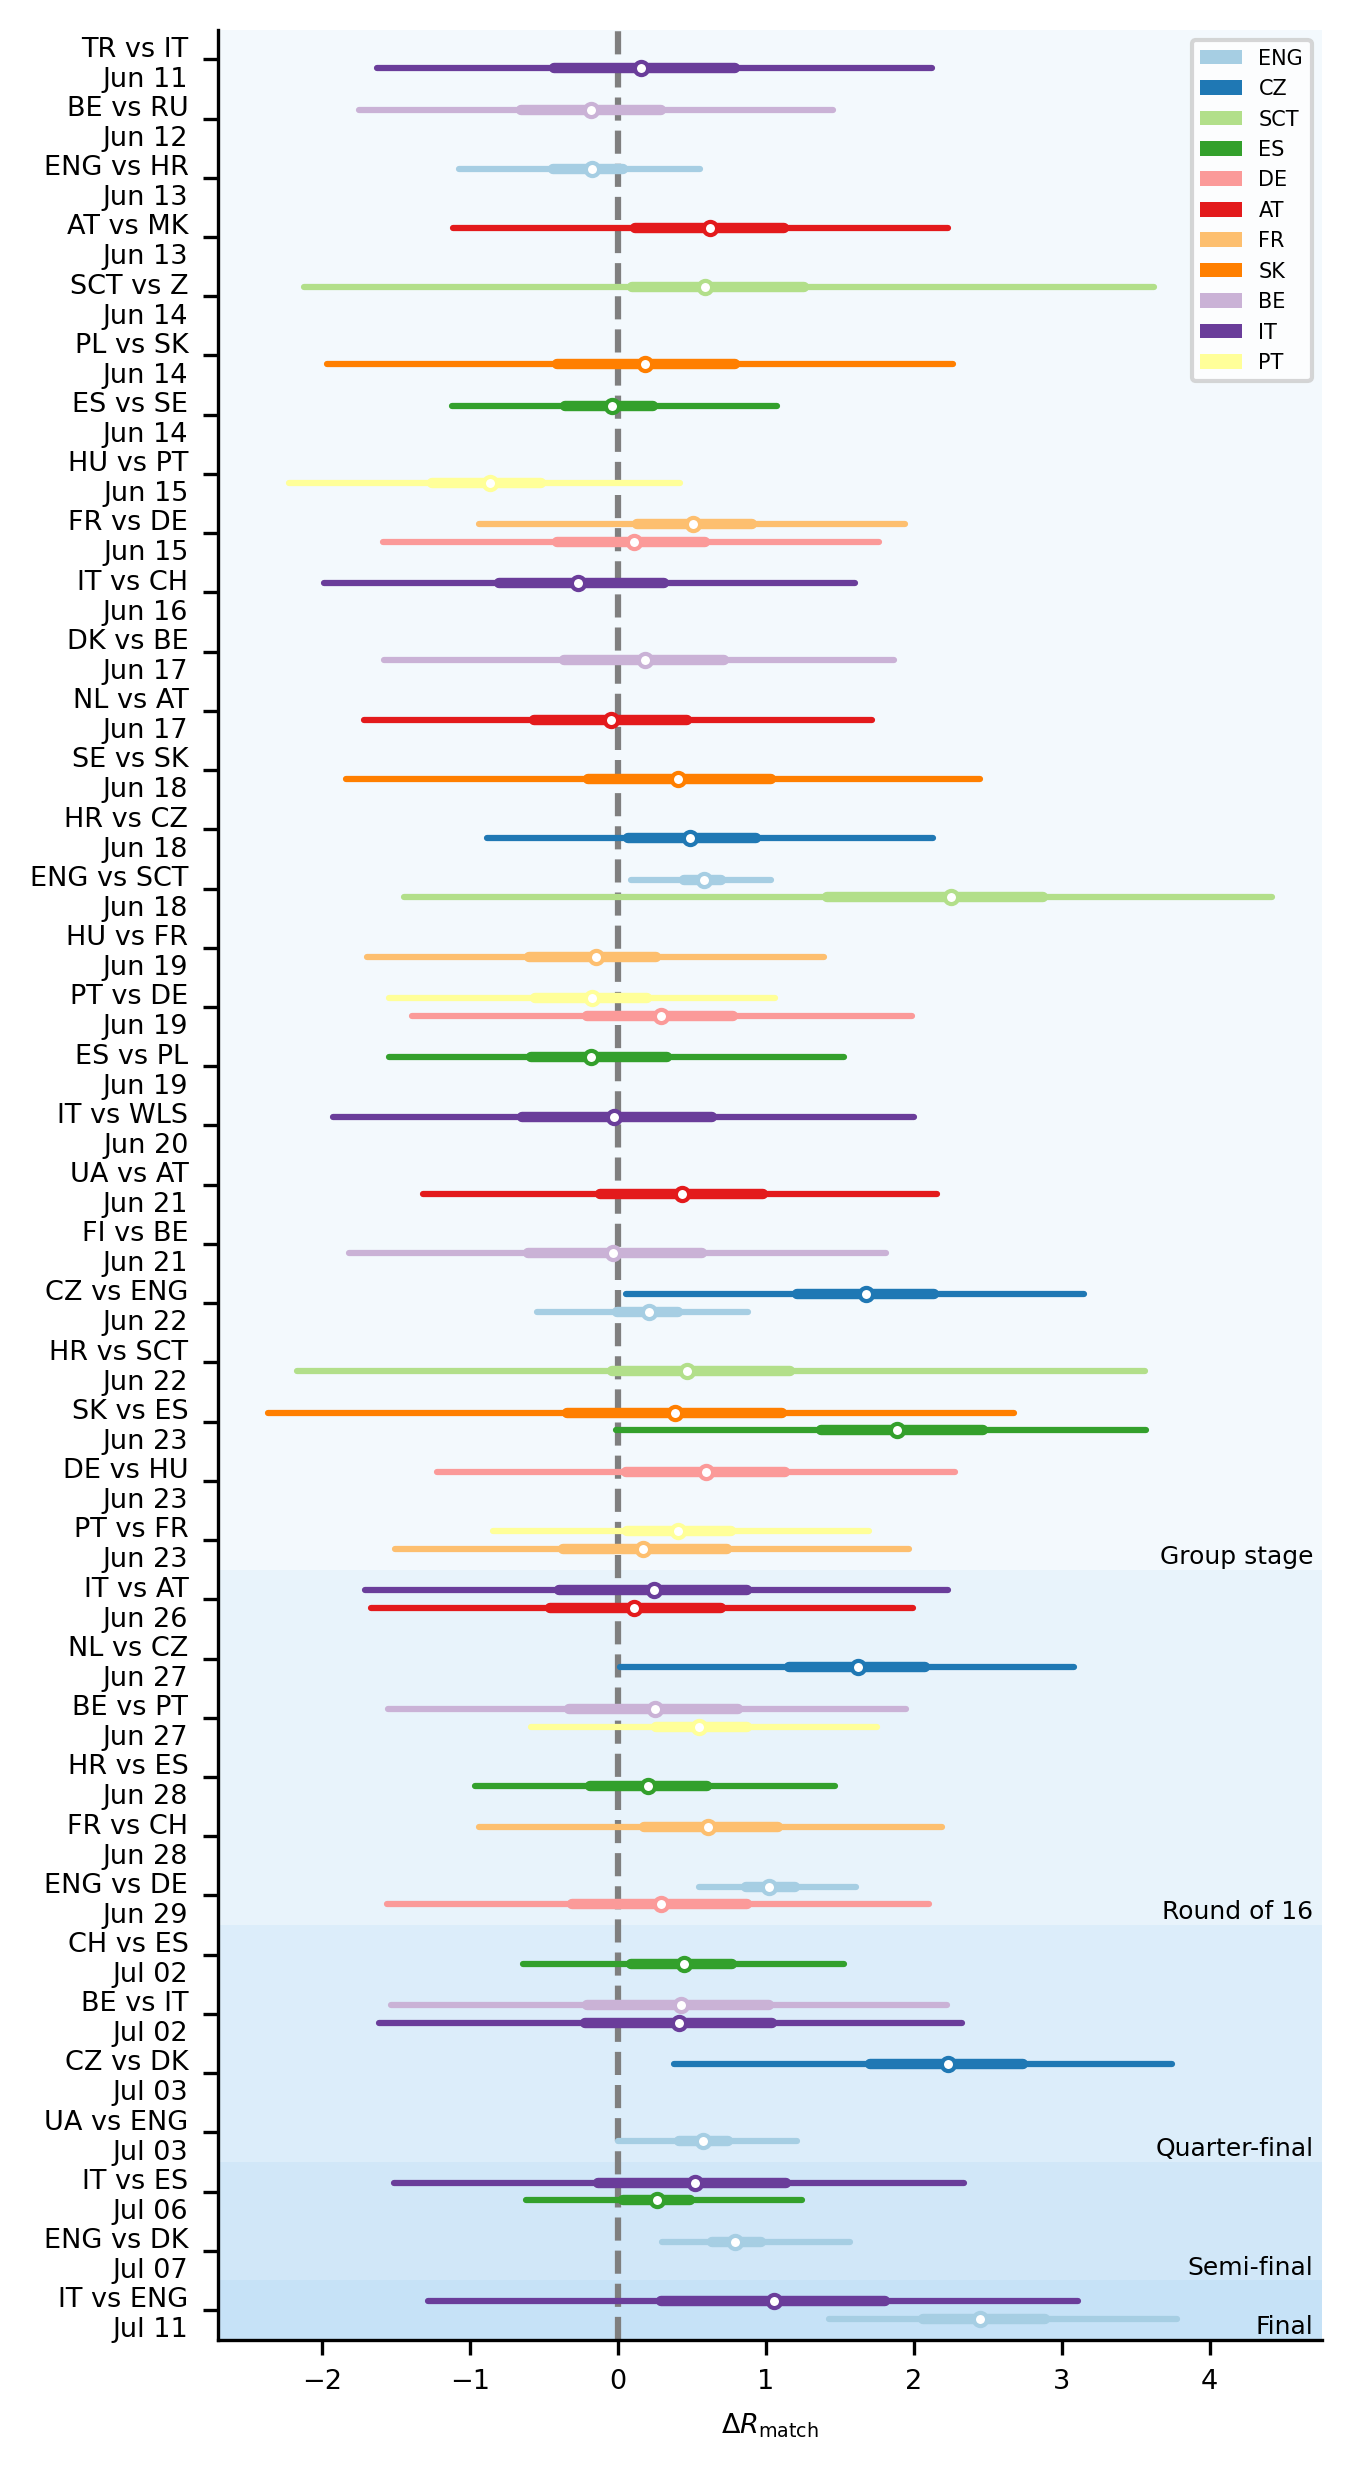

In [20]:
# Iterate timetable
def legend(ax,colors,loc="center"):
    # Legend
    image_urls = []
    iso2 = []
    for i, dl in enumerate(dls):
        image_urls.append(get_flag(dl.countries_iso2[0].lower(),"/tmp/"))
        iso2.append(dl.countries_iso2[0].replace("GB-", ""))
        
        
        
    lines = []
    for i,color in enumerate(colors):
        lines.append(MulticolorPatch(colors=[color]))
    ax.legend(
        lines,
        iso2,
        loc=loc,
        handler_map={MulticolorPatch:MulticolorPatchHandler()},
    )
    
fig,ax = plt.subplots(1,1,figsize=(4.75,10))
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

iso2_codes = np.array([dl.countries_iso2[0] for dl in dls])
c = 0
ticklabels = []
ticks = []
prev_phase = "GS"
for i, match in timetable.iterrows():
    team1 = match[" team1"][1:]
    team2 = match[" team2"][1:]
    phase_match = match[" phase"][1:]
    
    index_team1 = np.argwhere(iso2_codes == team1)[:,0]
    index_team2 = np.argwhere(iso2_codes == team2)[:,0]
    
    if index_team1.shape[0] == 0 and index_team2.shape[0] == 0:
        # skip if both teams are not found!
        continue
    if index_team1.shape[0] > 0:
        index_team1 = index_team1[0]
        dl = dls[index_team1]
        trace = traces[index_team1]
        index_alpha = int(dl.alpha_prior[0][:i].sum())
        
        data = get_from_trace("Delta_alpha_g_sparse",trace)[:,index_alpha]+get_from_trace("alpha_mean",trace)
        plot_var(ax, data, c-0.75, color=colors[index_team1])
    if index_team2.shape[0] > 0:
        index_team2 = index_team2[0]
        dl = dls[index_team2]
        trace = traces[index_team2]
        index_alpha = int(dl.alpha_prior[0][:i].sum())
        
        data = get_from_trace("Delta_alpha_g_sparse",trace)[:,index_alpha]+get_from_trace("alpha_mean",trace)
        plot_var(ax, data, c+0.75, color=colors[index_team2])
    
    
    if phase_match != "GS" and prev_phase=="GS":
        xlim = ax.get_xlim()
        ax.fill_between(
            x=(-1000,1000),
            y1=-2.5,
            y2=c-2.5,
            color=rcParams.color_championship_range,
            alpha=0.2,
            edgecolor="none"
        )
        ax.text(
            x=4.7,
            y=c-2.5-0.5,
            s="Group stage",
            ha="right",
            fontsize=6)
        c_gs = c
        ax.set_xlim(xlim)
    if phase_match != "AF" and prev_phase=="AF":
        xlim = ax.get_xlim()
        ax.fill_between(
            x=(-1000,1000),
            y1=c_gs-2.5,
            y2=c-2.5,
            color=rcParams.color_championship_range,
            alpha=0.4,
            edgecolor="none"
        )
        ax.text(
            x=4.7,
            y=c-2.5-0.5,
            s="Round of 16",
            ha="right",
            fontsize=6)
        c_gs = c
        ax.set_xlim(xlim)
    if phase_match != "VF" and prev_phase=="VF":
        xlim = ax.get_xlim()
        ax.fill_between(
            x=(-1000,1000),
            y1=c_gs-2.5,
            y2=c-2.5,
            color=rcParams.color_championship_range,
            alpha=0.6,
            edgecolor="none"
        )
        ax.text(
            x=4.7,
            y=c-2.5-0.5,
            s="Quarter-final",
            ha="right",
            fontsize=6)
        c_gs = c
        ax.set_xlim(xlim)   
    if phase_match != "HF" and prev_phase=="HF":
        xlim = ax.get_xlim()
        ax.fill_between(
            x=(-1000,1000),
            y1=c_gs-2.5,
            y2=c-2.5,
            color=rcParams.color_championship_range,
            alpha=0.8,
            edgecolor="none"
        )
        ax.text(
            x=4.7,
            y=c-2.5-0.5,
            s="Semi-final",
            ha="right",
            fontsize=6)
        c_gs = c
        ax.set_xlim(xlim)

    date_match = match[" date"].strftime(rcParams.date_format)
    ticklabels.append(f"{team1.replace('GB-','')} vs {team2.replace('GB-','')}\n{date_match}")
    ticks.append(c)
    prev_phase = phase_match
    c+=5

    
# Mrk final
xlim = ax.get_xlim()
ax.fill_between(
    x=(-1000,1000),
    y1=c_gs-2.5,
    y2=c-2.5,
    color=rcParams.color_championship_range,
    alpha=1,
    edgecolor="none"
)
ax.text(
    x=4.7,
    y=c-2.5-0.5,
    s="Final",
    fontsize=6,
    ha="right"
)
c_gs = c
ax.set_xlim(xlim)

# Markup
ax.axvline(0,ls="--",color="tab:gray")
ax.set_ylim(c-5+2.5,-2.5)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
ax.set_xlabel(r"$\Delta R_\mathrm{match}$")

legend(ax,colors,loc="upper right")


plt.show()
fig.savefig(f"../figures/SI/R_match.pdf", **save_kwargs)
fig.savefig(f"../figures/SI/R_match.png", **save_kwargs)
plt.close(fig=fig)


In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Sep 06 2022

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.24.1

pymc3     : 3.11.2
arviz     : 0.11.4
numpy     : 1.20.3
matplotlib: 3.5.1
pandas    : 1.2.4
sys       : 3.8.10 | packaged by conda-forge | (default, May 11 2021, 07:01:05) 
[GCC 9.3.0]

Watermark: 2.3.1

